## Centroid-based Density Clustering

Centroid-Based Density Clustering is an unsupervised machine learning algorithm that groups similar datapoints using centroids (center of cluster). Data points that are similary distanced to a cluster are considered part of the cluster/group.

The algorithm works by iteratively updating the centroid of a cluster(s) to minimize the distance of neighboring data points. This process stops when the cluster achieves a specified inertia (resistance to movement). 

Each centroid has a defined radii, which effectively creates a circle of vision that scans for neighboring data points. If no points are found, the centroid is randomly repositioned, while maintaining a specified padding with other clusters.

In [46]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [47]:
class Cluster:
    
    def __init__(self, centroid, radius, min_neighbors):

        self.centroid = centroid
        self.neighbors = []
        self.radius = radius
        self.min_neighbors = min_neighbors
        self.prev_inertia = float("inf")

    def get_neighbors(self, data):

        return np.array([row[1] for row in data.iterrows() if np.sum((row[1]-self.centroid)**2) <= self.radius**2])
    
    def calc_inertia(self, new_centroid, old_centroid):

        return np.sum((new_centroid - old_centroid) ** 2) ** (1/2)

    def update_centroid(self, data):

        self.neighbors = self.get_neighbors(data)

        old_centroid = self.centroid

        if len(self.neighbors) >= self.min_neighbors:

            distances = self.neighbors - self.centroid

            superposition = np.average(distances, axis=0)

            self.centroid += superposition

            self.prev_inertia = self.calc_inertia(self.centroid, old_centroid)

            return True
        
        return False

    


class KMeans:

    def __init__(self, min_inertia, cluster_radius, min_neighbors, k, cluster_padding):

        self.min_inertia = min_inertia
        self.cluster_radius = cluster_radius
        self.min_neighbors = min_neighbors
        self.k = k
        self.cluster_padding = cluster_padding
        self.clusters = []
        self.min_max_feat_vals = None
    
    def reposition_centroid(self, cls):

        coords = np.array([(MAX - MIN) * np.random.random_sample() + MIN for MIN, MAX in self.min_max_featvals])

        for cluster in [c for c in self.clusters if c != cls]:

            dist = np.sum((cluster.centroid - coords)**2) ** (1/2)

            if dist < self.cluster_padding:

                while dist < self.cluster_padding:

                    coords = np.array([(MAX - MIN) * np.random.random_sample() + MIN for MIN, MAX in self.min_max_featvals])
                    dist = np.sum((cluster.centroid - coords)**2) ** (1/2)
        
        cls.centroid = coords
    
    def init_clusters(self, data): #randomly places centroids with padding between each other and bounded by the min and max features values

        self.min_max_featvals = [(data[feat].min(), data[feat].max()) for feat in data.columns]

        for _ in range(self.k):

            coords = np.array([(MAX - MIN) * np.random.random_sample() + MIN for MIN, MAX in self.min_max_featvals])

            for cluster in self.clusters:

                dist = np.sum((cluster.centroid - coords)**2) ** (1/2)

                if dist < self.cluster_padding:

                    while dist < self.cluster_padding:

                        coords = np.array([(MAX - MIN) * np.random.random_sample() + MIN for MIN, MAX in self.min_max_featvals])
                        dist = np.sum((cluster.centroid - coords)**2) ** (1/2)
                
            self.clusters.append(Cluster(centroid=coords, radius=self.cluster_radius, min_neighbors=self.min_neighbors))
    
    def fit(self, data):

        self.init_clusters(data)

        remaining_clusters = [c for c in self.clusters]

        while remaining_clusters:
            
            for cls in remaining_clusters:

                success = cls.update_centroid(data)

                if not success:

                    self.reposition_centroid(cls)
                
                if cls.prev_inertia < self.min_inertia:

                    remaining_clusters.remove(cls)




In [48]:
X, centroids = make_blobs(n_samples= 100, centers = 5, cluster_std=0.5, random_state=42)


In [49]:
kmeans = KMeans(0.1, 2, 1, 5, 5)
path = kmeans.fit(pd.DataFrame(X))
path = np.array(path)

[[ 1.9593865   5.20487737]
 [-8.90658435  7.43743614]
 [-6.88347441 -6.86428675]
 [-2.74060587  8.83775566]
 [ 4.68987821  1.99621954]]


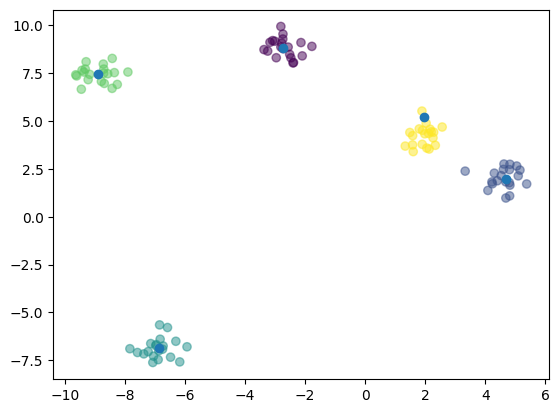

In [50]:
clusters = np.array([cls.centroid for cls in kmeans.clusters])
print(clusters)
plt.scatter(X[:, 0], X[:, 1], c=centroids, alpha=0.5)
plt.scatter(clusters[:, 0], clusters[:, 1])
